##### Copyright 2021 The TensorFlow Authors.

# Inspecting Quantization Errors with Quantization Debugger

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/quantization_debugger"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/quantization_debugger.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/quantization_debugger.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/performance/quantization_debugger.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

### Setup

This section prepares libraries, MobileNet v3 model, and test dataset of 100
images.

In [1]:
#!jupyter nbconvert --to script Q.ipynb
!jupytext --set-formats ipynb,py Q.ipynb --sync
# Quantization debugger is available from TensorFlow 2.7.0
!pip uninstall -y tensorflow
!pip install tf-nightly
#!pip install tensorflow_datasets --upgrade  # imagenet_v2 needs latest checksum
#!pip install tensorflow_hub

!pip install pandas
!pip install matplotlib

[jupytext] Reading Q.ipynb in format ipynb
[jupytext] Updating notebook metadata with '{"jupytext": {"formats": "ipynb,py"}}'
[jupytext] Updating Q.py


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
#import tensorflow_datasets as tfds
#import tensorflow_hub as hub

from tensorflow.lite.python import convert
import pickle
import os
import sys

2023-02-17 22:16:13.320565: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-17 22:16:13.328938: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-02-17 22:16:13.391772: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-02-17 22:16:13.392337: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 22:16:14.263494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
server=0

p="/home/ehsan/UvA/Accuracy/Keras/Yolov3/"
p_server="/home/ehsan/Accuracy/"
if server:
    p=p_server
data_dir = p+"Dataset/val2017"
image_size = (608, 608)
N=300


resdir='Yolo_files/'
ModelName=resdir+'Yolov3.h5'
QuantizedName=resdir+'YoloV3_quztized.tflite'
QSelectiveName=resdir+'YoloV3_selective_quztized.tflite'
UQSelectiveName=resdir+'YoloV3_selective_unquztized.tflite'
RESULTS_FILE = resdir+'yolov3_debugger_results.csv'
RESULTS_FILE_Propogate = resdir+'yolov3_debugger_propogate_results.csv'
DebuggerName=resdir+'Debugger_Yolov3.pkl'
DebuggerPropogateName=resdir+'Debugger_Yolov3_propogation.pkl'
CalibratedName=resdir+'YoloV3_calibrated.tflite'


# Define the input shape and data type
input_shape = (1, 608, 608, 3)
input_dtype = tf.float32

# Define the output shape and data type
output_shape = (1,)
output_dtype = tf.float32



In [4]:
def load_model(m=ModelName):
    model = tf.keras.models.load_model(m)
    return model





# Define a function to load and preprocess each image
def preprocess_image(file_path):
	# Load the image
	image = tf.io.read_file(file_path)
	# Decode the JPEG image to a tensor
	image = tf.image.decode_jpeg(image, channels=3)
	# Resize the image to the desired size
	image = tf.image.resize(image, image_size)
	# Normalize the pixel values to the range [0, 1]
	image = image / 255.0
	return image

#train_dataset = tf.data.Dataset.from_tensor_slices((images))
#train_dataset=train_dataset.map(process_image)
def load_dataset():
	# Create a list of file paths to the JPEG images
	file_paths = tf.data.Dataset.list_files(data_dir + "/*.jpg")
	# Use the map() method to apply the preprocessing function to each image
	dataset = file_paths.map(preprocess_image)
	#dataset = dataset.map(lambda x: {'input_1': x})
	return dataset



'''
def gen_rep():
    train_dataset=prepare_dataset()    
    representative_dataset = train_dataset.take(100).batch(1)
    return representative_dataset
    
def representative_dataset(dataset):
	def _data_gen():
		for data in dataset.batch(1):
			yield [data['image']]
	return _data_gen
'''



"\ndef gen_rep():\n    train_dataset=prepare_dataset()    \n    representative_dataset = train_dataset.take(100).batch(1)\n    return representative_dataset\n    \ndef representative_dataset(dataset):\n\tdef _data_gen():\n\t\tfor data in dataset.batch(1):\n\t\t\tyield [data['image']]\n\treturn _data_gen\n"

In [5]:

#representative_dataset = dataset.take(300).batch(1)
def rep(_dataset,n=N):
    def representative_dataset():
        for img in _dataset.take(n):
            #img = tf.cast(img, tf.float32)
            yield {'input_1': np.array([img])}
            #yield np.array(img)
    #return tf.data.Dataset.from_generator(representative_dataset, {'input_1': tf.float32}, {'input_1': tf.TensorShape([1, None, None, 3])})
    return representative_dataset

def rep2(_dataset,n=N):
    def representative_dataset():
        for img in _dataset.take(n):
            #img = tf.cast(img, tf.float32)
            
            #img = tf.expand_dims(img, axis=0)
            #yield [np.array(img)]
            
            yield [np.array([img])]
    return representative_dataset

def rep3(_dataset,n=N):
    for img in _dataset.take(n):
        yield [np.array([img])]

def quantize(model,_dataset,name=QuantizedName):
    print("\n\n\n\n***************************************************")
    print("quantization...\n")
    if (os.path.isfile(QuantizedName)):
        print(f"loading existed {QuantizedName}")
        with open(name, 'rb') as f:
            quantized_model=f.read()
    else:
        print(f'quantization: producing file {QuantizedName}')
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.representative_dataset = tf.lite.RepresentativeDataset(rep(_dataset))
        converter.representative_dataset = rep2(_dataset,N)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        quantized_model = converter.convert()
        open(name, "wb").write(quantized_model)
    return quantized_model

def explore(model,_dataset,debugger_name=DebuggerName):
    print("\n\n\n\n***************************************************")
    print("explore...\n")
    if (os.path.isfile(DebuggerName)):
        print(f'loading existed file {DebuggerName}')
        with open(debugger_name, 'rb') as f:
            debugger=pickle.load(f)
    elif (os.path.isfile(RESULTS_FILE)):
        print(f'explore not required, existed file {RESULTS_FILE}')
        return 
    else:
        print(f'explore: producing file {DebuggerName}...')
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        #converter.representative_dataset = rep2(_dataset,N)
        converter.representative_dataset = tf.lite.RepresentativeDataset(rep2(_dataset))
        # my_debug_dataset should have the same format as my_representative_dataset
        #debug_dataset=tf.lite.RepresentativeDataset(rep3(_dataset))
        debugger = tf.lite.experimental.QuantizationDebugger(
            converter=converter, debug_dataset=rep2(_dataset))
        #with open(debugger_name, 'wb') as f:
        #    pickle.dump(debugger, f)

    return debugger

def run_debugger(debugger,res_file):
    print("\n\n\n\n***************************************************")
    print("run debugger...\n")
    if not (os.path.isfile(res_file)):
        print(f'run_debugger: producing file {res_file}')
        debugger.run()
        with open(res_file, 'w') as f:
            debugger.layer_statistics_dump(f)
    else:
        print(f'run_debugger: file is existed; {res_file}')

def Analyze(res_file,t=-.33):
    print("\n\n\n\n***************************************************")
    print("Analyze...\n")
    layer_stats = pd.read_csv(res_file)
    layer_stats.head()
    layer_stats['range'] = 255.0 * layer_stats['scale']
    layer_stats['rmse/scale'] = layer_stats.apply(
        lambda row: np.sqrt(row['mean_squared_error']) / row['scale'], axis=1)
    layer_stats[['op_name', 'range', 'rmse/scale']].head()
    plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(121)
    ax1.bar(np.arange(len(layer_stats)), layer_stats['range'])
    ax1.set_ylabel('range')
    ax2 = plt.subplot(122)
    ax2.bar(np.arange(len(layer_stats)), layer_stats['rmse/scale'])
    ax2.set_ylabel('rmse/scale')
    plt.show()
    #print(layer_stats[layer_stats['rmse/scale'] > t][['op_name', 'range', 'rmse/scale', 'tensor_name']])
    layer_stats.to_csv(res_file)

def selective_quantize(model,_dataset,t=0.33):
    print("\n\n\n\n***************************************************")
    print("selective quantization...\n")
    if (os.path.isfile(QSelectiveName)):
        print(f'selective quantization: loading existed file {QSelectiveName}')
        with open(QSelectiveName, "rb") as f:
            selective_quantized_model=f.read()
    else:
        print(f'selective_quatize: producing file {QSelectiveName}')
        layer_stats = pd.read_csv(RESULTS_FILE)
        suspected_layers = list(
            layer_stats[layer_stats['rmse/scale'] > t]['tensor_name'])
        suspected_layers.extend(list(layer_stats[:5]['tensor_name']))

        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = rep(_dataset,N)
        debug_options = tf.lite.experimental.QuantizationDebugOptions(denylisted_nodes=suspected_layers)
        debugger = tf.lite.experimental.QuantizationDebugger(
            converter=converter,debug_dataset=rep(_dataset,N),debug_options=debug_options)
        selective_quantized_model = debugger.get_nondebug_quantized_model()
        open(QSelectiveName, "wb").write(selective_quantized_model)
    return selective_quantized_model

def calibrate(model,_dataset,name=CalibratedName):
    print("\n\n\n\n***************************************************")
    print("calibrate...\n")
    if (os.path.isfile(CalibratedName)):
        print(f'calibrate: loading existing file {CalibratedName}')
        with open(name, 'rb') as f:
            calibrated_model = f.read()
    else:
        print(f"calibrate producing file {CalibratedName}")
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.representative_dataset = rep2(_dataset)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter._experimental_calibrate_only = True
        converter.inference_input_type = input_dtype
        converter.inference_output_type = output_dtype
        converter.inference_input_shape = input_shape
        converter.inference_output_shape = output_shape
        calibrated_model = converter.convert()
        open(name, "wb").write(calibrated_model)
    return calibrated_model
    



def explore_propogation(calibrated_model,_dataset,debugger_name=DebuggerPropogateName):
    print("\n\n\n\n***************************************************")
    print("explore propogation...\n")
    if (os.path.isfile(DebuggerPropogateName)):
        print(f'explore propogation: loading existed file {DebuggerPropogateName}')
        with open(debugger_name, 'rb') as f:
            debugger=pickle.load(f)
    elif (os.path.isfile(RESULTS_FILE_Propogate)):
        print(f'explore propogate not required, existed file {RESULTS_FILE_Propogate}')
        return
    else:
        print(f"explore_propogation: Producing file {DebuggerPropogateName}")
        # Note that enable_numeric_verify and enable_whole_model_verify are set.
        quantized_model = convert.mlir_quantize(
            calibrated_model,
            enable_numeric_verify=True,
            enable_whole_model_verify=True)
        debugger = tf.lite.experimental.QuantizationDebugger(
            quant_debug_model_content=quantized_model,
            debug_dataset=rep2(_dataset))
        #with open(debugger_name, 'wb') as f:
        #    pickle.dump(debugger, f)
    return debugger

def explore_combinations(calibrated_model,suspected_layers=[],t=0.35,name=UQSelectiveName):
    print("\n\n\n\n***************************************************")
    print("explore combination...\n")
    if (os.path.isfile(name)):
        print(f'explore combinations: loading existed file {name}')
        with open(name, 'rb') as f:
            selective_quantized_model = f.read()
    else:
        print(f"explore_combinations: producing file {name}")
        layer_stats = pd.read_csv(RESULTS_FILE)
        suspected_layers.extend(list(layer_stats[layer_stats['rmse/scale'] > t]['tensor_name']))
        suspected_layers.extend(list(layer_stats[:10]['tensor_name']))
        selective_quantized_model = convert.mlir_quantize(calibrated_model, denylisted_nodes=suspected_layers)
        open(name, "wb").write(selective_quantized_model)
    return selective_quantized_model

'''
def amend_input(m=CalibratedName):
    interpreter = tf.lite.Interpreter(model_path=m)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    input_shape = input_details[0]['shape']
    input_shape[1] = 608
    input_shape[2] = 608
    interpreter.resize_tensor_input(0, input_shape)
    interpreter.allocate_tensors()
    print(interpreter.get_input_details())
    converter = tf.lite.TFLiteConverter.from_interpreter(interpreter)
    #converter.allow_custom_ops = True  # If you have any custom ops in your model
    tflite_model = converter.convert()
    with open('modified_model.tflite', 'wb') as f:
        f.write(tflite_model)

'''

"\ndef amend_input(m=CalibratedName):\n    interpreter = tf.lite.Interpreter(model_path=m)\n    interpreter.allocate_tensors()\n\n    input_details = interpreter.get_input_details()\n    input_shape = input_details[0]['shape']\n    input_shape[1] = 608\n    input_shape[2] = 608\n    interpreter.resize_tensor_input(0, input_shape)\n    interpreter.allocate_tensors()\n    print(interpreter.get_input_details())\n    converter = tf.lite.TFLiteConverter.from_interpreter(interpreter)\n    #converter.allow_custom_ops = True  # If you have any custom ops in your model\n    tflite_model = converter.convert()\n    with open('modified_model.tflite', 'wb') as f:\n        f.write(tflite_model)\n\n"

In [6]:
model=load_model(m=ModelName)
model.summary()
dataset=load_dataset()
# Print the first 5 images in the dataset
for image in dataset.take(5):
	print(image.shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_0 (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, None, None,   128         ['conv_0[0][0]']                 
                                32)                                                         

2023-02-17 22:16:17.355552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5000]
	 [[{{node Placeholder/_0}}]]
2023-02-17 22:16:17.355707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5000]
	 [[{{node Placeholder/_0}}]]






***************************************************
calibrate...

calibrate: loading existing file Yolo_files/YoloV3_calibrated.tflite




***************************************************
quantization...

loading existed Yolo_files/YoloV3_quztized.tflite




***************************************************
explore...

explore: producing file Yolo_files/Debugger_Yolov3.pkl...


2023-02-17 22:16:20.002446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-02-17 22:16:20.211645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-02-17 22:16:25.967072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-02-17

INFO:tensorflow:Assets written to: /tmp/tmptc55flpv/assets


INFO:tensorflow:Assets written to: /tmp/tmptc55flpv/assets
/home/ehsan/anaconda3/envs/Quantize/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-02-17 22:16:39.633194: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-02-17 22:16:39.633223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-02-17 22:16:39.633874: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptc55flpv
2023-02-17 22:16:39.653545: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-02-17 22:16:39.653576: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptc55flpv
2023-02-17 22:16:39.715461: I tensorflow/compiler





***************************************************
run debugger...

run_debugger: producing file Yolo_files/yolov3_debugger_results.csv




***************************************************
Analyze...



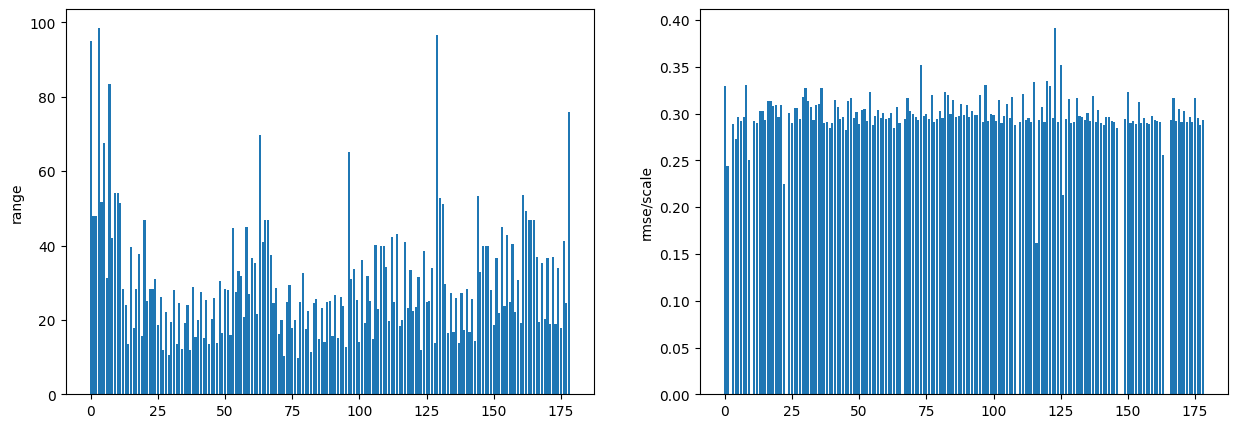





***************************************************
selective quantization...

selective quantization: loading existed file Yolo_files/YoloV3_selective_quztized.tflite




***************************************************
calibrate...

calibrate: loading existing file Yolo_files/YoloV3_calibrated.tflite




***************************************************
explore propogation...

explore_propogation: Producing file Yolo_files/Debugger_Yolov3_propogation.pkl


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32
2023-02-17 23:03:55.743163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5000]
	 [[{{node Placeholder/_0}}]]
2023-02-17 23:03:55.743346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5000]
	 [[{{node Placeholder/_0}}]]






***************************************************
run debugger...

run_debugger: producing file Yolo_files/yolov3_debugger_propogate_results.csv




***************************************************
Analyze...



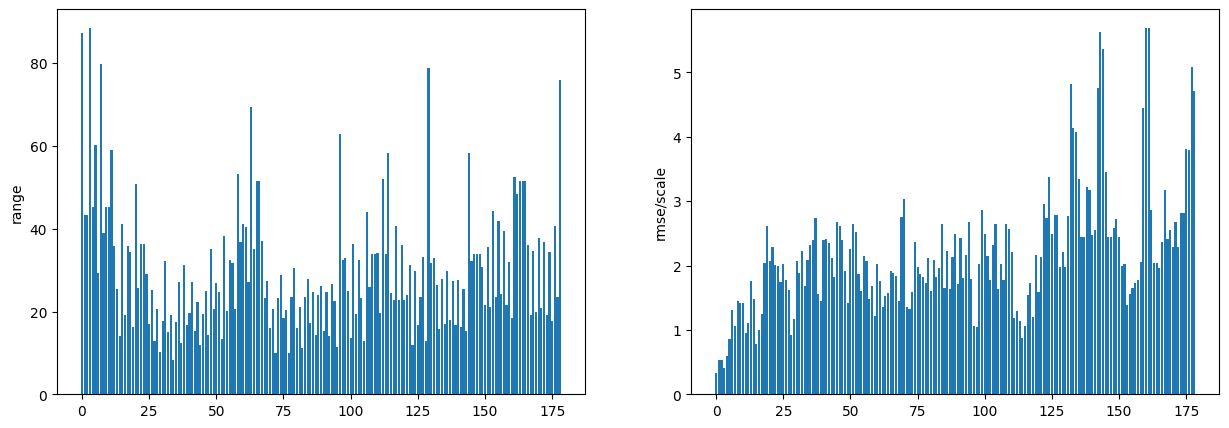





***************************************************
calibrate...

calibrate: loading existing file Yolo_files/YoloV3_calibrated.tflite




***************************************************
explore combination...

explore combinations: loading existed file Yolo_files/YoloV3_selective_unquztized.tflite


In [7]:
calibrated_model=calibrate(model,dataset)

quantized_model=quantize(model,dataset)

debugger=explore(model,dataset)


run_debugger(debugger,RESULTS_FILE)
Analyze(RESULTS_FILE)
selective_quantized=selective_quantize(model,dataset)

calibrated_model=calibrate(model,dataset)
debugger=explore_propogation(calibrated_model,dataset)
run_debugger(debugger,RESULTS_FILE_Propogate)
Analyze(RESULTS_FILE_Propogate)
calibrated_model=calibrate(model,dataset)
selective_unquantized=explore_combinations(calibrated_model)